<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook plots KL clustering results for the iNs mRNAseq

<strong>Input Data:</strong>

``run_partitioning_bulkRNAseq.py``

<strong>Figures:</strong>

`Fig3`
`Fig4`
`ED9`

<strong>Last Run All:</strong>
June 20, 2025



In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
import json
import numpy as np
from ABCA7lof2.utils import apply_custom_plot_style
apply_custom_plot_style()
from ABCA7lof2.kl_additional_plotting import get_scores_per_cluster, plot_densities, plot_rep_names, get_top_genes, get_names_per_cluster, return_partitioning, get_gene_pathway_matrix, get_jaccard_matrix, adjust_pvalues, sort_matrix, plot_jaccard_matrix, plot_direction_colors, get_layout, plot_graph

def load_degs(path):
    data1 = pd.read_csv(path, index_col=0)
    data1.index = data1['genes']
    data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
    return data1

def plot_jaccard_overlap(frame1, frame2, scores1, scores2, title, ylabel, xlabel, prefix1, prefix2,  label_y=-0.5, n_iter=1000):
    jaccard_g2_y622, pvalues_g2_y622 = get_jaccard_matrix(frame1, frame2, n_iter)
    adjusted_pvalues_g2_y622 = adjust_pvalues(pvalues_g2_y622)
    new_row_order_g2_y622, new_col_order_g2_y622 = sort_matrix(jaccard_g2_y622)

    iN_clusters = [prefix2+str(x) for x in np.unique(frame2['new_cluster'])]
    iN_G2_clusters = [prefix1+str(x) for x in np.unique(frame1['new_cluster'])]

    plt.figure(figsize=(3.5, 2.5))

    plot_jaccard_matrix(jaccard_g2_y622, adjusted_pvalues_g2_y622, new_row_order_g2_y622, new_col_order_g2_y622, title, xlabel, ylabel, label_y=-0.5)

    plt.yticks(ticks=np.arange(len(new_row_order_g2_y622)), labels=np.array(iN_G2_clusters)[new_row_order_g2_y622])
    plt.xticks(ticks=np.arange(len(new_col_order_g2_y622)), labels=np.array(iN_clusters)[new_col_order_g2_y622], rotation=90)
    plt.gca().tick_params(axis='both', which='both', length=0)

    # Get the current axis to modify tick label colors
    ax = plt.gca()
    plot_direction_colors(iN_G2_clusters, iN_clusters, scores1, scores2, new_row_order_g2_y622, new_col_order_g2_y622, ax)
    return {'jaccard': jaccard_g2_y622, 'adjusted_pvalues': adjusted_pvalues_g2_y622}

def plot_graph_full(frame, mat, out_path, colors_dict, s=10000):
    graph_y622, pos_y622, cur_labels_y622, unique_clusters_y622, _, layout_y622 = get_layout(frame, mat, s, 10)
    D = dict(zip(frame['new_cluster_mapped'], frame['cluster']))
    unique_clusters_y622 = [D[x] for x in np.unique(frame['new_cluster_mapped'])]

    plot_graph(layout_y622, pos_y622, graph_y622, cur_labels_y622, unique_clusters_y622, [colors_dict[x] for x in np.unique(frame['new_cluster_mapped'])], out_path)

Return partitions

In [2]:
# load the iN data
with open("../../processed_data/bulkRNAseq_fgsea_leading_edge2.json", 'r') as file:
    data = json.load(file)

path_to_paths = '../../processed_data/WikiPathways_2019_Human.npy'

# get the gene clusters
frame_pm = pd.read_csv('../../processed_data/pm_kl_frame.csv', index_col=0)
G2_frame, G2_mat = return_partitioning(path_to_paths, 'wt_g2', '../../processed_data/kl_loss_wt_g2.npy', data)
Y622_frame, Y622_mat = return_partitioning(path_to_paths, 'wt_y622', '../../processed_data/kl_loss_wt_y622.npy', data)
Choline_frame, Choline_mat = return_partitioning(path_to_paths, 'y622_choline', '../../processed_data/kl_loss_y622_choline.npy', data)

# make Y clusters continue from PM, and G2 clusters continue from Y
Y622_frame['new_cluster'] = Y622_frame['cluster'] + np.max(frame_pm['cluster'])
G2_frame['new_cluster'] = G2_frame['cluster'] + np.max(Y622_frame['new_cluster'])
Choline_frame['new_cluster'] = Choline_frame['cluster'] + np.max(G2_frame['new_cluster'])
frame_pm['new_cluster'] = frame_pm['cluster']

(111, 356)


3it [00:06,  2.07s/it, tot_impr=700, last_impr=0, loss=473]  


(110, 334)


3it [00:00,  6.57it/s, tot_impr=671, last_impr=0, loss=354]  


(138, 313)


3it [00:00,  7.01it/s, tot_impr=960, last_impr=0, loss=827]  


Load degs

In [3]:
# load degs
y622_degs = load_degs('../../bulkRNAseq/y622_degs.csv')
choline_degs = load_degs('../../bulkRNAseq/choline_degs.csv')
g2_degs = load_degs('../../bulkRNAseq/g2_degs.csv')

# get scores
scores_Y622 = get_scores_per_cluster(y622_degs, Y622_frame, 'new_cluster')
scores_choline = get_scores_per_cluster(choline_degs, Choline_frame, 'new_cluster')
scores_g2 = get_scores_per_cluster(g2_degs, G2_frame, 'new_cluster')

# get pm scores
scores = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)
scores['score'] = scores['Ex']
scores_pm = get_scores_per_cluster(scores, frame_pm, 'new_cluster')


Plot Jaccard Overlaps

100%|██████████| 10/10 [00:33<00:00,  3.33s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


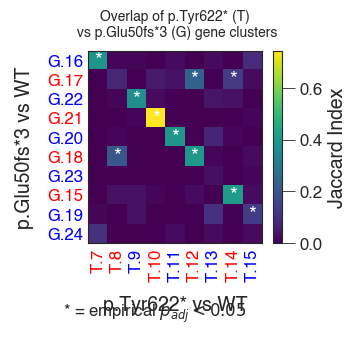

In [4]:
g2_y622_out = plot_jaccard_overlap(G2_frame, Y622_frame, scores_g2, scores_Y622, 
                     'Overlap of p.Tyr622* (T)\n vs p.Glu50fs*3 (G) gene clusters',  
                     'p.Glu50fs*3 vs WT', 'p.Tyr622* vs WT', 
                     n_iter=1000, prefix1='G.', prefix2='T.')
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed9/jaccard_pT622_pG50fs3_vs_wt.svg', bbox_inches='tight', dpi=300)

100%|██████████| 10/10 [00:31<00:00,  3.19s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


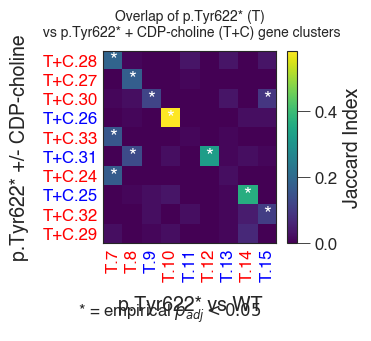

In [5]:
choline_y622_out = plot_jaccard_overlap(Choline_frame, Y622_frame, scores_choline, scores_Y622, 
                     'Overlap of p.Tyr622* (T)\n vs p.Tyr622* + CDP-choline (T+C) gene clusters',  
                    'p.Tyr622* +/- CDP-choline', 'p.Tyr622* vs WT', 
                     n_iter=1000, prefix1='T+C.', prefix2='T.')
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/jaccard_pT622_with_choline.pdf', bbox_inches='tight', dpi=300)

100%|██████████| 8/8 [00:26<00:00,  3.32s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


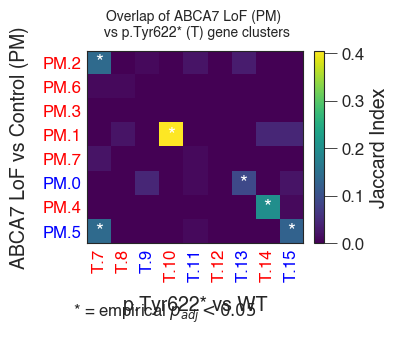

In [6]:
pm_y622_out = plot_jaccard_overlap(frame_pm, Y622_frame, scores_pm, scores_Y622, 
                   'Overlap of ABCA7 LoF (PM) \n vs p.Tyr622* (T) gene clusters',  
                    'ABCA7 LoF vs Control (PM)', 'p.Tyr622* vs WT', 
                     n_iter=1000, prefix1='PM.', prefix2='T.')
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig3/jaccard_PM_pT622_new.pdf')#, bbox_inches='tight', dpi=300)

100%|██████████| 8/8 [00:28<00:00,  3.51s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


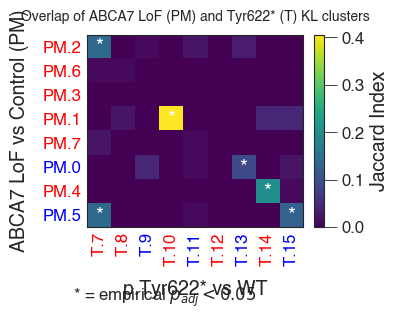

In [7]:
pm_y622_out = plot_jaccard_overlap(frame_pm, Y622_frame, scores_pm, scores_Y622, 
                   'Overlap of ABCA7 LoF (PM) and Tyr622* (T) KL clusters',  
                    'ABCA7 LoF vs Control (PM)', 'p.Tyr622* vs WT', 
                     n_iter=1000, prefix1='PM.', prefix2='T.')
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/jaccard_PM_pT622_new.svg')#, bbox_inches='tight', dpi=300)

In [8]:
pm_y622_out

{'jaccard': array([[0.        , 0.        , 0.04301075, 0.        , 0.01041667,
         0.        , 0.08888889, 0.        , 0.02105263],
        [0.        , 0.0212766 , 0.        , 0.4057971 , 0.        ,
         0.        , 0.        , 0.04347826, 0.04347826],
        [0.13953488, 0.        , 0.01041667, 0.        , 0.02105263,
         0.        , 0.03157895, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.2       , 0.01052632],
        [0.13953488, 0.        , 0.        , 0.        , 0.01041667,
         0.        , 0.        , 0.        , 0.12790698],
        [0.01041667, 0.01052632, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.02105263, 0.        , 0.        , 0.        , 0.01052632,
         0.        , 0.        

100%|██████████| 8/8 [00:29<00:00,  3.74s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


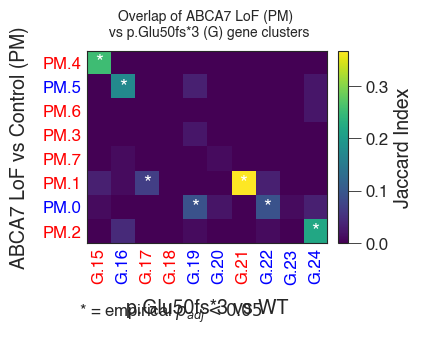

In [9]:
pm_g2_out = plot_jaccard_overlap(frame_pm, G2_frame, scores_pm, scores_g2, 
                   'Overlap of ABCA7 LoF (PM) \n vs p.Glu50fs*3 (G) gene clusters',  
                    'ABCA7 LoF vs Control (PM)', 'p.Glu50fs*3 vs WT', 
                     n_iter=1000, prefix1='PM.', prefix2='G.')
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed9/g2_pm_jaccard.svg', bbox_inches='tight', dpi=300)

In [10]:
# Map PM to Y
best_matches = np.argmax(pm_y622_out['jaccard'], axis=0)
best_match_pvals = [pm_y622_out['adjusted_pvalues'][best_matches[i],i] for i in range(len(best_matches))]
best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
pm_to_y = dict(zip(np.arange(pm_y622_out['jaccard'].shape[1]),best_matches_filtered))
Y622_frame['new_cluster_mapped'] = ['PM.'+str(pm_to_y[x]) for x in Y622_frame['cluster']]
Y622_frame['new_cluster_mapped'] = ['T.' + str(Y622_frame['new_cluster'][i]) if Y622_frame['new_cluster_mapped'][i]=='PM.nan' else Y622_frame['new_cluster_mapped'][i] for i in range(len(Y622_frame['new_cluster']))]


# Map Y to YC
dictionary = dict(zip(Y622_frame['cluster'], Y622_frame['new_cluster_mapped']))
best_matches = np.argmax(choline_y622_out['jaccard'].T, axis=0)
best_match_pvals = [choline_y622_out['adjusted_pvalues'].T[best_matches[i],i] for i in range(len(best_matches))]
best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
y_to_yc = dict(zip(np.arange(choline_y622_out['jaccard'].shape[0]),[dictionary.get(x, float('nan')) for x in best_matches_filtered]))
Choline_frame['new_cluster_mapped'] = [str(y_to_yc[x]) for x in Choline_frame['cluster']]
Choline_frame['new_cluster_mapped'] = ['T+C.' + str(Choline_frame['new_cluster'][i]) if Choline_frame['new_cluster_mapped'][i]=='nan' else Choline_frame['new_cluster_mapped'][i] for i in range(len(Choline_frame['new_cluster']))]


# Map PM to G
best_matches = np.argmax(pm_g2_out['jaccard'], axis=0)
best_match_pvals = [pm_g2_out['adjusted_pvalues'][best_matches[i],i] for i in range(len(best_matches))]
best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
pm_to_g = dict(zip(np.arange(pm_g2_out['jaccard'].shape[1]),best_matches_filtered))
G2_frame['new_cluster_mapped'] = ['PM.'+str(pm_to_g[x]) for x in G2_frame['cluster']]
G2_frame['new_cluster_mapped'] = ['G.' + str(G2_frame['new_cluster'][i]) if G2_frame['new_cluster_mapped'][i]=='PM.nan' else G2_frame['new_cluster_mapped'][i] for i in range(len(G2_frame['new_cluster']))]

# add new cluster column to PM
frame_pm['new_cluster_mapped'] = ['PM.'+str(x) for x in frame_pm['cluster']]

In [11]:
colors_dict = {'PM.3': (0.847, 0.106, 0.376, 1.0),
 'PM.4': (0.902, 0.318, 0.0, 1.0),
 'PM.2': (1.0, 0.549, 0.0, 1.0),
 'T+C.29': (1.0, 0.718, 0.302, 1.0),
 'PM.1': (0.082, 0.396, 0.753, 1.0),
 'PM.5': (0.18, 0.49, 0.196, 1.0),
 'PM.0': (0.941, 0.384, 0.573, 1.0),
 'T.12': (0.259, 0.647, 0.961, 1.0),
 'T.11': (0.4, 0.733, 0.416, 1.0),
 'G.20': (0.89, 0.106, 0.137, 1.0),
 'T.8': (0.6, 0.196, 0.8, 1.0),
 'G.23': (1.0, 0.843, 0.0, 1.0),
 'PM.7': (0.251, 0.878, 0.816, 1.0),
 'G.18': (0.647, 0.165, 0.165, 1.0),
 'PM.6': (0.0, 0.5, 0.5, 1.0),
 'T.9': (1.0, 0.0, 1.0, 1.0)}

plot layout

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


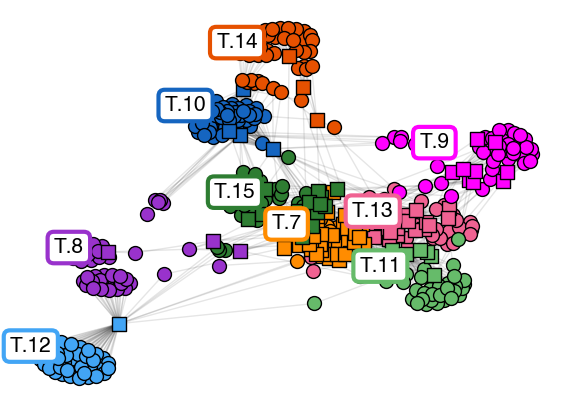

In [12]:
Y622_frame['cluster'] = ['T.' + str(x) for x in Y622_frame['new_cluster']]
plot_graph_full(Y622_frame, Y622_mat, '/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig3/y622_kl_clusters', colors_dict, 10000)


In [13]:
np.unique(Choline_frame['new_cluster_mapped'])

array(['PM.1', 'PM.2', 'PM.4', 'PM.5', 'T+C.29', 'T.12', 'T.8', 'T.9'],
      dtype=object)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


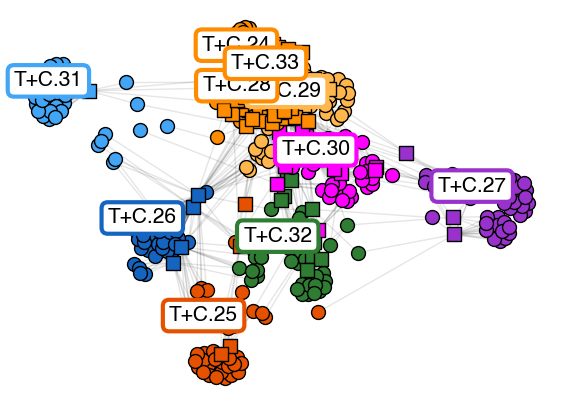

In [14]:
# get graph layout for choline treatment
Choline_frame['cluster'] = ['T+C.' + str(x) for x in Choline_frame['new_cluster']]
s=10000
graph_choline, pos_choline, cur_labels_choline, unique_clusters_choline, colors_choline, layout_choline = get_layout(Choline_frame, Choline_mat, s, 10)

D = dict(zip(Choline_frame['new_cluster_mapped'], Choline_frame['cluster']))
unique_clusters_choline = [D[x] for x in np.unique(Choline_frame['new_cluster_mapped'])]
unique_clusters_choline.append('T+C.28')
unique_clusters_choline.append('T+C.33')
C = [colors_dict[x] for x in np.unique(Choline_frame['new_cluster_mapped'])]
C.append(colors_dict['PM.2'])
C.append(colors_dict['PM.2'])

out_path = '/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/Y622_choline_kl_network'
plot_graph(layout_choline, pos_choline, graph_choline, cur_labels_choline, unique_clusters_choline, C, out_path)

Because multiple clusters map to the same PM cluster, have to make a small adjustment to the code:

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


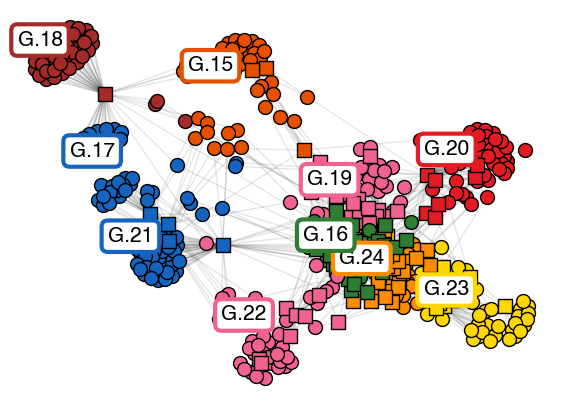

In [15]:
# get graph layout for y622
G2_frame['cluster'] = ['G.' + str(x) for x in G2_frame['new_cluster']]
s=10000
graph_g2, pos_g2, cur_labels_g2, unique_clusters_g2, colors_g2, layout_g2 = get_layout(G2_frame, G2_mat, s, 10)

D = dict(zip(G2_frame['new_cluster_mapped'], G2_frame['cluster']))
unique_clusters_g2 = [D[x] for x in np.unique(G2_frame['new_cluster_mapped'])]
unique_clusters_g2.append('G.17')
unique_clusters_g2.append('G.22')

out_path = '/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed9/g2_kl_clusters'
C = [colors_dict[x] for x in np.unique(G2_frame['new_cluster_mapped'])]
C.append(colors_dict['PM.1'])
C.append(colors_dict['PM.0'])
plot_graph(layout_g2, pos_g2, graph_g2, cur_labels_g2, unique_clusters_g2, C, out_path)

Get rep names

In [16]:
G2_frame['new_cluster2'] = ['G.' + str(x) for x in G2_frame['new_cluster']]
Y622_frame['new_cluster2'] = ['T.' + str(x) for x in Y622_frame['new_cluster']]
Choline_frame['new_cluster2'] = ['T+C.' + str(x) for x in Choline_frame['new_cluster']]

# get scores
scores_Y622 = get_scores_per_cluster(y622_degs, Y622_frame, 'new_cluster2')
scores_choline = get_scores_per_cluster(choline_degs, Choline_frame, 'new_cluster2')
scores_g2 = get_scores_per_cluster(g2_degs, G2_frame, 'new_cluster2')

names_y622 = dict(zip(np.unique(Y622_frame['new_cluster2']), get_names_per_cluster(Y622_mat, Y622_frame, 'new_cluster2', 3)))
names_choline = dict(zip(np.unique(Choline_frame['new_cluster2']), get_names_per_cluster(Choline_mat, Choline_frame, 'new_cluster2', 3)))
names_g2 = dict(zip(np.unique(G2_frame['new_cluster2']), get_names_per_cluster(G2_mat, G2_frame, 'new_cluster2', 3)))


plot pathway densities

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/kl_additional_plotting.py:228: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/kl_additional_plotting.py:228: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

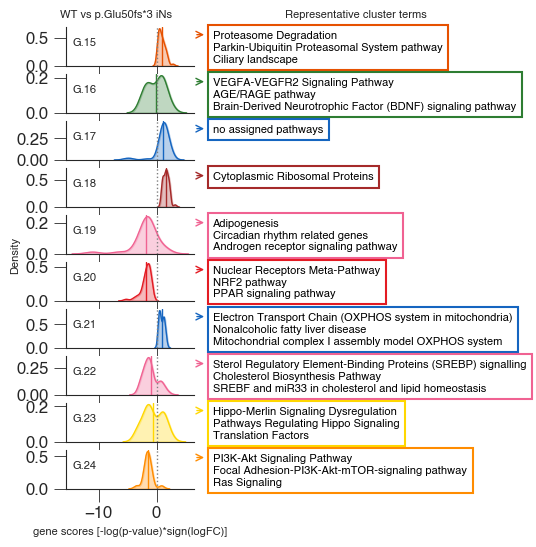

In [17]:
names_g2['G.17'] = ['no assigned pathways']
colors_dict_new = dict(zip(G2_frame['new_cluster2'], [colors_dict[x] for x in G2_frame['new_cluster_mapped']]))
plot_densities(scores_g2, colors_dict_new, names_g2, np.unique(G2_frame['new_cluster2']), 'WT vs p.Glu50fs*3 iNs', figsize=(2.5, 6))
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed9/kl_densities_g.pdf', bbox_inches='tight', dpi=300)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/kl_additional_plotting.py:228: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/kl_additional_plotting.py:228: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

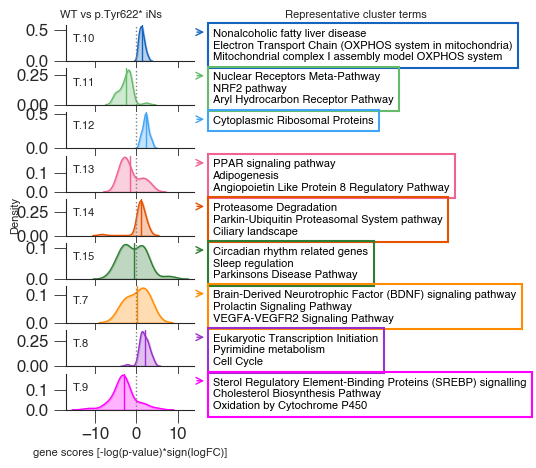

In [18]:
colors_dict_new = dict(zip(Y622_frame['new_cluster2'], [colors_dict[x] for x in Y622_frame['new_cluster_mapped']]))

plot_densities(scores_Y622, colors_dict_new, names_y622, np.unique(Y622_frame['new_cluster2']), 'WT vs p.Tyr622* iNs', figsize=(2.5, 5))
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig3/kl_densities_Tyr622.pdf', bbox_inches='tight', dpi=300)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/kl_additional_plotting.py:228: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/kl_additional_plotting.py:228: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

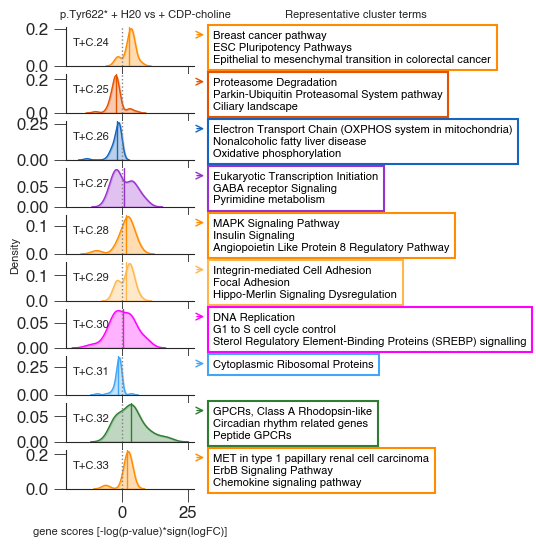

In [19]:
colors_dict_new = dict(zip(Choline_frame['new_cluster2'], [colors_dict[x] for x in Choline_frame['new_cluster_mapped']]))

plot_densities(scores_choline, colors_dict_new, names_choline, np.unique(Choline_frame['new_cluster2']), 'p.Tyr622* + H20 vs + CDP-choline', figsize=(2.5, 6))
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/kl_densities_choline.pdf', bbox_inches='tight', dpi=300)

In [20]:
# save KL results to Supp tables
G2_frame.to_csv('/Users/djuna/Documents/ABCA7lof2/extended_tables/G2_frame.csv')
Y622_frame.to_csv('/Users/djuna/Documents/ABCA7lof2/extended_tables/Y622_frame.csv')
Choline_frame.to_csv('/Users/djuna/Documents/ABCA7lof2/extended_tables/Choline_frame.csv')

In [22]:
frame_pm.to_csv('/Users/djuna/Documents/ABCA7lof2/extended_tables/frame_pm.csv')